# Experiments on Multi-Arm Bandit problems with RL

This notebook experiments simple RL experimentations. <br>
It follows the book **Reinforcement Learning: An Introduction** from *Sutton* and *Barto*. 

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

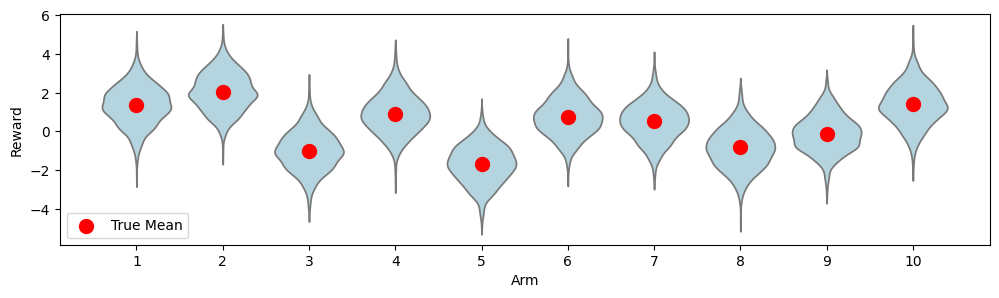

In [31]:
# Generate 10-armed testbed
num_arms = 10

def generate_test(num_arms: int): 

    # True reward means for each arm
    # Each arm has a distribution N(true_mean, 1)
    true_means = np.random.normal(0, 1, num_arms)
    
    return true_means

# Let's do an example: 
true_means = generate_test(num_arms)

# Plot the distributions: violin plots for each arm
plt.figure(figsize=(12, 3))

# First, plot all violin plots
for i in range(num_arms):
    sns.violinplot(x=[i+1]*1000, y=np.random.normal(true_means[i], 1, 1000), inner=None, color='lightblue')

# Then, overlay the true means on top
for i in range(num_arms):
    plt.scatter(i, true_means[i], color='red', s=100, zorder=10, label='True Mean' if i == 0 else "")

plt.xlabel('Arm')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [3]:
def init_value_estimates(num_arms: int, initial_value: float = 0.0):
    return np.full(num_arms, initial_value)

init_value_estimates(num_arms)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:

from typing import Dict


def run_arm(arm_index: int, true_means: np.ndarray):
    return np.random.normal(true_means[arm_index], 1)

def greedy_pick_arm(value_estimates: np.ndarray):
    return np.argmax(value_estimates)

def greedy_iteration(value_estimates: np.ndarray, true_means: np.ndarray, chosen_actions: Dict[int, int], rewards: Dict[int, float]):
    """Runs an iteration of the greedy algorithm

    Args:
        value_estimates (np.ndarray): the current value estimates for each arm
        true_means (np.ndarray): the true means of each arm
        chosen_actions (Dict[int, int], optional): the history of chosen actions. Dict of <action index>: <count>. 
        rewards (Dict[int, float], optional): _description_. Dict of <action index>: <total reward>.
    """
    # 1. Pick the best arm according to current estimates
    chosen_arm = greedy_pick_arm(value_estimates)
    
    # 2. Run the chosen arm and get reward
    arm_reward = run_arm(chosen_arm, true_means)
    
    # 3. Update value estimates
    rewards[chosen_arm] = rewards.get(chosen_arm, 0.0) + arm_reward
    chosen_actions[chosen_arm] = chosen_actions.get(chosen_arm, 0) + 1
    
    updated_estimate = rewards[chosen_arm] / chosen_actions[chosen_arm]
    
    value_estimates[chosen_arm] = updated_estimate
    
    return (value_estimates, chosen_actions, rewards, arm_reward)

def greedy(true_means: np.ndarray, time_steps: int):
    """Runs the whole greedy algorithm for the given multi-arm bandit problem (defined as the true means of each arm)

    Args:
        true_means (np.ndarray): the true means of each arm
        time_steps (int): number of time steps to run

    Returns:
        _type_: _description_
    """
    value_estimates = init_value_estimates(num_arms)
    
    rewards = np.zeros(time_steps)
    chosen_actions = {}
    rewards_dict = {}
    
    for t in range(time_steps):
        value_estimates, chosen_actions, rewards_dict, arm_reward = greedy_iteration(value_estimates, true_means, chosen_actions, rewards=rewards_dict)
        rewards[t] = arm_reward
    
    return rewards


In [19]:
def e_greedy_pick_arm(value_estimates: np.ndarray, epsilon: float):
    if np.random.rand() < epsilon:
        return np.random.randint(len(value_estimates))
    else:
        return np.argmax(value_estimates)
    
def e_greedy_iteration(epsilon: float, value_estimates: np.ndarray, true_means: np.ndarray, chosen_actions: Dict[int, int], rewards: Dict[int, float]):
    """Runs an iteration of the epsilon_greedy algorithm

    Args:
        value_estimates (np.ndarray): the current value estimates for each arm
        true_means (np.ndarray): the true means of each arm
        chosen_actions (Dict[int, int], optional): the history of chosen actions. Dict of <action index>: <count>. 
        rewards (Dict[int, float], optional): _description_. Dict of <action index>: <total reward>.
    """
    # Pick the best arm (or explore)
    chosen_arm = e_greedy_pick_arm(value_estimates, epsilon=epsilon)
    
    # Run the chosen arm and get reward
    arm_reward = run_arm(chosen_arm, true_means)
    
    # Update value estimates
    rewards[chosen_arm] = rewards.get(chosen_arm, 0.0) + arm_reward
    chosen_actions[chosen_arm] = chosen_actions.get(chosen_arm, 0) + 1
    
    updated_estimate = rewards[chosen_arm] / chosen_actions[chosen_arm]
    value_estimates[chosen_arm] = updated_estimate
    
    return (value_estimates, chosen_actions, rewards, arm_reward)

def e_greedy(epsilon: float, true_means: np.ndarray, time_steps: int):
    """Runs the whole greedy algorithm for the given multi-arm bandit problem (defined as the true means of each arm)

    Args:
        true_means (np.ndarray): the true means of each arm
        time_steps (int): number of time steps to run

    Returns:
        _type_: _description_
    """
    value_estimates = init_value_estimates(num_arms)
    
    rewards = np.zeros(time_steps)
    chosen_actions = {}
    rewards_dict = {}
    
    for t in range(time_steps):
        
        # Run the iteration
        value_estimates, chosen_actions, rewards_dict, arm_reward = e_greedy_iteration(epsilon, value_estimates, true_means, chosen_actions, rewards=rewards_dict)
        
        rewards[t] = arm_reward
        
    return rewards

In [34]:
import time


n_problems = 2000
time_steps = 2000

rewards = np.zeros((n_problems, time_steps))
e_greedy_rewards = np.zeros((n_problems, time_steps))
e_greedy_rewards_0_01 = np.zeros((n_problems, time_steps))

for p in range(n_problems):
    
    # Generate arm reward distributions for the problem
    true_means = generate_test(num_arms)
    
    # Run greedy algorithm
    rewards[p] = greedy(true_means, time_steps)
    
    # Run e-greedy algorithm
    e_greedy_rewards[p] = e_greedy(0.1, true_means, time_steps)
    e_greedy_rewards_0_01[p] = e_greedy(0.01, true_means, time_steps)

avg_rewards = np.mean(rewards, axis=0)
avg_e_greedy_rewards = np.mean(e_greedy_rewards, axis=0)
avg_e_greedy_rewards_0_01 = np.mean(e_greedy_rewards_0_01, axis=0)

## Comparison of the different Algorithms

As shown in the book, We can see that the e-greedy algorithm performs better, and the one with $\epsilon=0.01$ converges slower but converges to higher rewards (performs better) than the one with $\epsilon=0.1$. 

As mentioned in the book, initializing with values > 0 instead of zeros, will probably achieve higher results because it forces exploration in the beginning. <br>
The logic being the following: 
- A (e-)greedy algo picks an arm
- The arm obtains a value taken from a Normal distribution N(0, 1), hence the value will most likely be less thab the positive (e.g. 5) value of the initialization
- That will force the algo to try another arm at the next rount 

<Axes: >

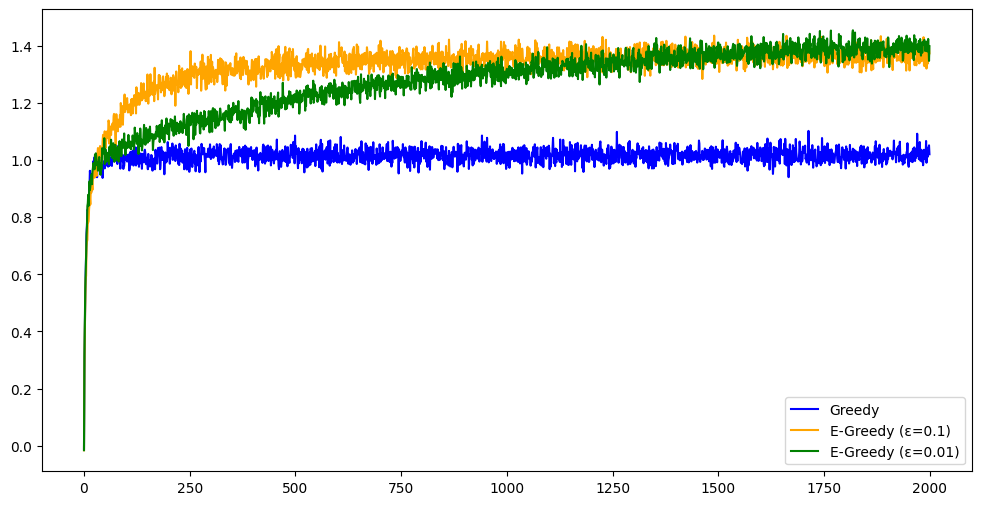

In [35]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=np.arange(time_steps), y=avg_rewards, label='Greedy', color='blue')
sns.lineplot(x=np.arange(time_steps), y=avg_e_greedy_rewards, label='E-Greedy (ε=0.1)', color='orange')
sns.lineplot(x=np.arange(time_steps), y=avg_e_greedy_rewards_0_01, label='E-Greedy (ε=0.01)', color='green')